In [1]:
import os,sys, re
from importlib import reload
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")


from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
#import MERFISH_probe_design.probe_design.OTTable_dict as ot

888146


In [2]:
from ChromAn.src.file_io.data_organization import Color_Usage, search_fovs_in_folders, color_usage_kwds

In [3]:
import ChromAn
reload(ChromAn.src.file_io.data_organization)
from ChromAn.src.file_io.data_organization import Data_Organization, search_fovs_in_folders
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [4]:
!ls /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2

Analysis    H0M1    H1M2  H3M4	H5M6  H7M8  H9M10    Tests
Experiment  H10M11  H2M3  H4M5	H6M7  H8M9  Mosaics


In [5]:
# where the original data saves
data_home =  r"/lab/weissman_imaging/puzheng/"
data_folder = os.path.join(data_home, 'Merfish_seq', '20230623-KPtumor_lung_c2')

experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage.csv')

20230623


In [6]:
# visualize some images:
folders, fovs = search_fovs_in_folders(data_folder)
sel_fov = 200

test_ref_filename = os.path.join(folders[0], fovs[sel_fov])
test_filename = os.path.join(folders[-1], fovs[sel_fov])
# load ref
daxp_ref = DaxProcesser(test_ref_filename)
daxp_ref._load_image()
#daxp_ref._corr_hot_pixels()
# load
daxp = DaxProcesser(test_filename)
daxp._load_image()
#daxp._corr_hot_pixels()
daxp._calculate_drift(RefImage=daxp_ref.im_488, FiducialChannel='488')

- searching in folder: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2
-- 11 folders, 507 fovs detected.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_200.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_200_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['750', '647', '488', '405'] in 0.710s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_200.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_200_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['750', '647', '488'] in 1.832s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image 

(array([ -0.05333333,  -0.16666667, -10.29333333]), 1)

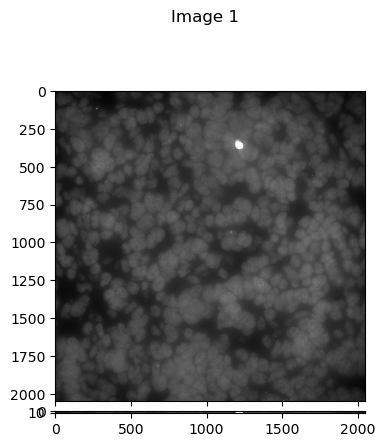

In [7]:
imshow_mark_3d([daxp.im_647])

### Quickly visualize bead image to find bead-localizing z-frame

<IPython.core.display.Javascript object>


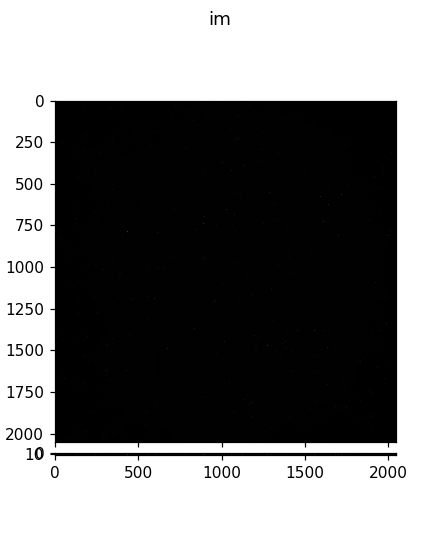

In [9]:
%matplotlib notebook
imshow_mark_3d([daxp.im_488, daxp_ref.im_488], image_names=['im', 'ref'])

<IPython.core.display.Javascript object>


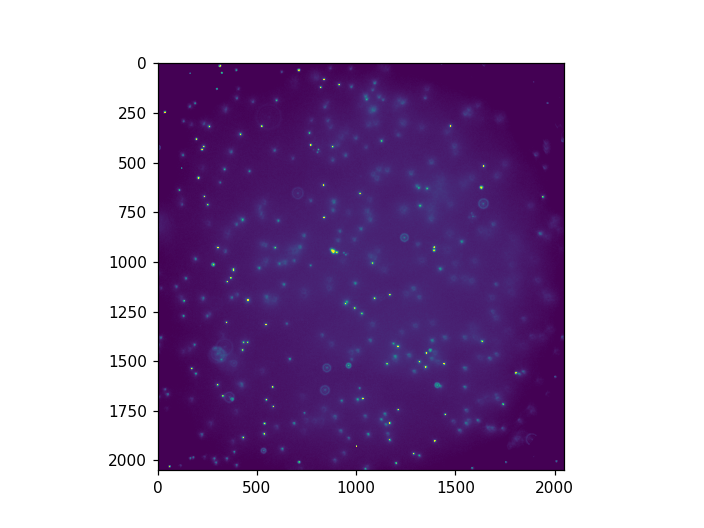

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp_ref.im_488[10], vmin=500, vmax=2000)

<IPython.core.display.Javascript object>


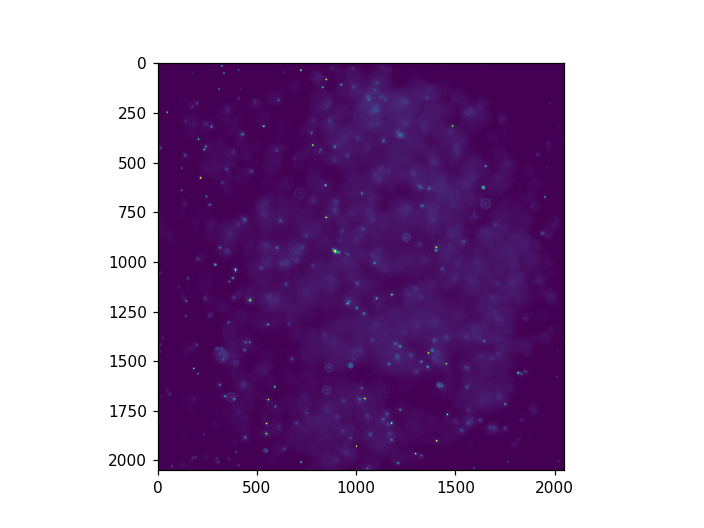

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp.im_488[10], vmin=500, vmax=2000)

In [12]:
ref_Zstep = 10 # start from 0, manually check several images

In [13]:
# Load readout names:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/C2'
readout_filename = os.path.join(library_folder, 'readouts.csv')

if os.path.exists(readout_filename):
    readouts = pd.read_csv(readout_filename) 
else:
    # generate readout_file
    import MERFISH_probe_design.IO.file_io as fio
    merfish_bits_file = os.path.join(r'/lab/solexa_weissman/puzheng/References/Readouts', 'MERFISH_readouts.fasta')
    merfish_bits = fio.load_fasta_into_df(merfish_bits_file)
    # first 22 bits are for this library:
    readouts = {'Name':[_id.split('-')[-1] for _id in merfish_bits.loc[:, 'id']], 
                'Sequence':merfish_bits.loc[:, 'sequence']}
    readouts = pd.DataFrame(readouts)
    # save this readout
    readouts.to_csv(readout_filename, index=None)
# select names
readout_names = list(readouts['Name'])[:20]

In [14]:
len(readout_names)

20

In [18]:
# Generate data organization
date = os.path.basename(data_folder).split('-')[0]
data_organization_filename = f'../../merlin_parameters/dataorganization/{date}-C2_{len(readout_names)}bit.csv'
_do = Data_Organization(data_organization_filename,)
if _do.is_empty():
    # create
    _do.create_from_colorUsage(color_usage_filename, data_folder,ref_Zstep, readout_names=readout_names)
    # save
    _do.save_to_file(overwrite=True)

- load color_usage from file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Analysis/color_usage.csv
- searching in folder: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2
-- 11 folders, 507 fovs detected.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
- 20 MERFISH rows appended.
- PolyT row appended.
- DAPI row appended.
Saving data_organization into file: ../../merlin_parameters/dataorganization/20230623-C2_20bit.csv.


In [19]:
ref_image_type = '748_637_477_405_s13' # ref 58 / 65
polyt_image_type = '748_637_477_s13'
image_type = '748_637_477_s13' # ref 36/39

In [20]:
_do

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,RS0015,750_647_488_405_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,0,750,[0 4 8 12 16 20 24 28 32 36 40 44 48 52 56],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_405_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,42,488
1,bit2,RS0083,750_647_488_405_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,0,647,[1 5 9 13 17 21 25 29 33 37 41 45 49 53 57],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_405_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,42,488
2,bit3,RS0095,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,1,750,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,32,488
3,bit4,RS0109,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,1,647,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,32,488
4,bit5,RS0175,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,5,2,750,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,32,488
5,bit6,RS0237,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,6,2,647,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,32,488
6,bit7,RS0247,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,7,3,750,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,32,488
7,bit8,RS0255,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,8,3,647,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,32,488
8,bit9,RS0307,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,9,4,750,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,32,488
9,bit10,RS0332,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,10,4,647,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43],[0.0 1.5 3.0 4.5 6.0 7.5 9.0 10.5 12.0 13.5 15...,750_647_488_s15,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,32,488


## Copy position file

In [21]:
from shutil import copyfile

In [22]:
position_filename = os.path.join(data_folder, 'Experiment', 'positions_all.txt')

target_position_filename = os.path.join(r"../../merlin_parameters/positions/", f"{experiment_date}_positions.txt")

if os.path.isfile(position_filename):
    print(f"source position file: {position_filename}")
    print(f"target position file: {target_position_filename}")
    # copy
    copyfile(position_filename, target_position_filename)
else:
    print(f"position file doesn't exist. Check this directory: {position_filename}")

source position file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Experiment/positions_all.txt
target position file: ../../merlin_parameters/positions/20230623_positions.txt
